Import modules as required|. 

To run this particular inplementation of gaussian processing, you'll need to install Eigen and George (more details here http://dfm.io/george/current/user/quickstart/)

In [1]:
import os, sys
import os.path
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import george
from george.kernels import ExpSquaredKernel, Matern32Kernel
import scipy.optimize as opt

Gradient functions for optimisation of the kernel size

In [2]:
def ll(p):
    gp.set_parameter_vector(p)
    return -gp.lnlikelihood(data['Mag'],quiet=True)

def grad_ll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(data['Mag'],quiet=True)

Load in whatever data you want to interpolate

In [3]:
data=pd.read_csv('iptf13bvn_V_band.dat',delim_whitespace=True,names=['MJD','Mag','MagErr'])

GP-ing requires you to 'scale' the data so all values are between 0 and 1

In [4]:
scale=data['Mag'].max()
data['Mag'] /= scale
data['MagErr'] /= scale

Pick a kernel to interpolate your data with (e.g. guassian, matern 3/2, 5/2 etc). The form of the kernal can greatly influence your final interpolation (e.g. if the kernel form has a broader peak, it will likely smooth over wobbly regions of data). Depends what you are trying to achieve with your interpolation. Here I've just imported an exponential squared and Matern 3/2 kernel, but there are plenty to choose from (see the manual). 

Once you've set your kernel you also set an initial kernel radius (in x-space, which here is MJD). You can also add white noise at this stage too if you like.

In [5]:
gp = george.GP(Matern32Kernel(500))
gp.compute(data['MJD'], data['MagErr'])
p0 = gp.kernel.get_parameter_vector()[0]

If you want to, you can optimise your kernel size for your data with the line below. However, this isn't nessessary (again, depends what science you want to get out of the interpolations). You can just comment out the next line if you want to use a fixed kernel size.

In [6]:
results = opt.minimize(ll, p0, jac=grad_ll)

Finally, create some artifical x-space for your GP interpolation, then calculate the resulting mean function and covariance matrix for the interpolation. 

In [7]:
t = np.linspace(data['MJD'].iloc[0],data['MJD'].iloc[-1],500)
mu, cov = gp.predict(data['Mag'], t)
std = np.sqrt(np.diag(cov))

Plot up your interpolation. Don't forget to re-scale your data!

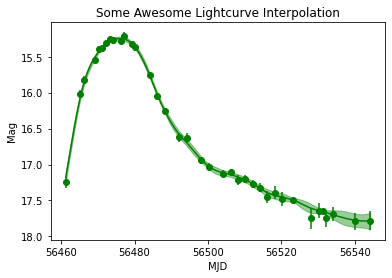

In [8]:
plt.errorbar(data['MJD'], data['Mag']*scale, yerr=data['MagErr']*scale, fmt='o',color='g')
plt.fill_between(t, (mu+std)*scale, (mu-std)*scale, color='green', alpha=0.4)
plt.plot(t, mu*scale,'g')
plt.gca().invert_yaxis()
plt.title('Some Awesome Lightcurve Interpolation')
plt.xlabel('MJD')
plt.ylabel('Mag')

plt.show()
